##Setup

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
!tar xf spark-3.2.1-bin-hadoop3.2.tgz

openjdk-8-jdk-headless is already the newest version (8u312-b07-0ubuntu1~18.04).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


## Setting Environment Variables

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.1-bin-hadoop3.2"
os.environ["PYTHONPATH"] = "%SPARK_HOME%\python;%SPARK_HOME%\python\lib\py4j-0.10.9.3-src.zip:%PYTHONPATH%"

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

## Loading Dataset

In [ ]:
from pyspark import SparkFiles
spark.sparkContext.addFile('https://raw.githubusercontent.com/sreekeshiyer/dmbi_aids_datasets/main/car_sales.csv')
df = spark.read.csv("file://"+SparkFiles.get("car_sales.csv"), header=True, inferSchema= True)

In [ ]:
df

DataFrame[Make: string, Model: string, Year: int, Engine Fuel Type: string, Engine HP: int, Engine Cylinders: int, Transmission Type: string, Driven_Wheels: string, Number of Doors: int, Market Category: string, Vehicle Size: string, Vehicle Style: string, highway MPG: int, city mpg: int, Popularity: int, MSRP: int]

In [ ]:
print('Data overview')
df.printSchema()

Data overview
root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: integer (nullable = true)
 |-- Engine Cylinders: integer (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: integer (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- highway MPG: integer (nullable = true)
 |-- city mpg: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- MSRP: integer (nullable = true)



In [ ]:
df.show(5)

+----+----------+----+--------------------+---------+----------------+-----------------+----------------+---------------+--------------------+------------+-------------+-----------+--------+----------+-----+
|Make|     Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|   Driven_Wheels|Number of Doors|     Market Category|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|
+----+----------+----+--------------------+---------+----------------+-----------------+----------------+---------------+--------------------+------------+-------------+-----------+--------+----------+-----+
| BMW|1 Series M|2011|premium unleaded ...|      335|               6|           MANUAL|rear wheel drive|              2|Factory Tuner,Lux...|     Compact|        Coupe|         26|      19|      3916|46135|
| BMW|  1 Series|2011|premium unleaded ...|      300|               6|           MANUAL|rear wheel drive|              2|  Luxury,Performance|     Compact|  Convertible

## Data Preprocessing

### Converting the data type of desired columns into IntegerType

In [ ]:
df.count()

11914

In [ ]:
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType

numeric_columns = ['Year','Engine HP','Engine Cylinders','Number of Doors','highway MPG','city mpg','Popularity','MSRP']
for column in numeric_columns:
    df = df.withColumn(column,f.col(column).cast(IntegerType()))
df.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: integer (nullable = true)
 |-- Engine Cylinders: integer (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: integer (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- highway MPG: integer (nullable = true)
 |-- city mpg: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- MSRP: integer (nullable = true)



In [ ]:
df = df.drop("Market Category")

### Handling Missing Values

In [ ]:
#Count the missing values in every column
for col in df.columns:
  print(df.filter(df[col].isNull()).count(), '\t', col)

0 	 Make
0 	 Model
0 	 Year
3 	 Engine Fuel Type
69 	 Engine HP
30 	 Engine Cylinders
0 	 Transmission Type
0 	 Driven_Wheels
6 	 Number of Doors
0 	 Vehicle Size
0 	 Vehicle Style
0 	 highway MPG
0 	 city mpg
0 	 Popularity
0 	 MSRP


In [ ]:
#Filling missing values with means
from pyspark.sql.functions import avg

def mean_of_pyspark_columns(df, numeric_cols, verbose=False):
    col_with_mean=[]
    for col in numeric_cols:
        mean_value = df.select(avg(df[col]))
        avg_col = mean_value.columns[0]
        res = mean_value.rdd.map(lambda row : row[avg_col]).collect()
        
        if (verbose==True): print(mean_value.columns[0], "\t", res[0])
        col_with_mean.append([col, res[0]])    
    return col_with_mean

#Fill missing values for mean
from pyspark.sql.functions import when, lit

def fill_missing_with_mean(df, numeric_cols):
    col_with_mean = mean_of_pyspark_columns(df, numeric_cols) 
    
    for col, mean in col_with_mean:
        df = df.withColumn(col, when(df[col].isNull()==True, 
        lit(mean)).otherwise(df[col]))
        
    return df

In [ ]:
numeric_cols=['Engine HP','Engine Cylinders']
df = fill_missing_with_mean(df, numeric_cols)

In [ ]:
#Count the missing values in every column
for col in df.columns:
  print(df.filter(df[col].isNull()).count(), '\t', col)

0 	 Make
0 	 Model
0 	 Year
3 	 Engine Fuel Type
0 	 Engine HP
0 	 Engine Cylinders
0 	 Transmission Type
0 	 Driven_Wheels
6 	 Number of Doors
0 	 Vehicle Size
0 	 Vehicle Style
0 	 highway MPG
0 	 city mpg
0 	 Popularity
0 	 MSRP


In [ ]:
#Filling missing values with mode
def mode_of_pyspark_columns(df, cat_col_list, verbose=False):
    col_with_mode=[]
    for col in cat_col_list:
        #Filter null
        df = df.filter(df[col].isNull()==False)
        #Find unique_values_with_count
        unique_classes = df.select(col).distinct().rdd.map(lambda x: x[0]).collect()
        unique_values_with_count=[]
        for uc in unique_classes:
             unique_values_with_count.append([uc, df.filter(df[col]==uc).count()])
        #sort unique values w.r.t their count values
        sorted_unique_values_with_count= sorted(unique_values_with_count, key = lambda x: x[1], reverse =True)
        
        if (verbose==True): print(col, sorted_unique_values_with_count, " and mode is ", sorted_unique_values_with_count[0][0])
        col_with_mode.append([col, sorted_unique_values_with_count[0][0]])
    return col_with_mode

#Fill missing values for mode
from pyspark.sql.functions import when, lit

def fill_missing_with_mode(df, cat_col_list):
    col_with_mode =mode_of_pyspark_columns(df, cat_col_list)
    
    for col, mode in col_with_mode:
        df = df.withColumn(col, when(df[col].isNull()==True, 
        lit(mode)).otherwise(df[col]))
        
    return df

In [ ]:
cat_col_list=['Engine Fuel Type']
df = fill_missing_with_mode(df, cat_col_list)

In [ ]:
#Count the missing values in every column
for col in df.columns:
  print(df.filter(df[col].isNull()).count(), '\t', col)

0 	 Make
0 	 Model
0 	 Year
0 	 Engine Fuel Type
0 	 Engine HP
0 	 Engine Cylinders
0 	 Transmission Type
0 	 Driven_Wheels
6 	 Number of Doors
0 	 Vehicle Size
0 	 Vehicle Style
0 	 highway MPG
0 	 city mpg
0 	 Popularity
0 	 MSRP


### Handling Outliers

In [ ]:
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [ ]:
new_df = find_outliers(df)
new_df.show()

+----+----------+----+--------------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+--------------+
|Make|     Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|    Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|total_outliers|
+----+----------+----+--------------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+--------------+
| BMW|1 Series M|2011|premium unleaded ...|    335.0|             6.0|           MANUAL| rear wheel drive|              2|     Compact|        Coupe|         26|      19|      3916|46135|             0|
| BMW|  1 Series|2011|premium unleaded ...|    300.0|             6.0|           MANUAL| rear wheel drive|              2|     Compact|  Convertible|         28|      19|      3916|40650| 

In [ ]:
new_df_with_no_outliers = new_df.filter(new_df['total_Outliers']<=1)
new_df_with_no_outliers = new_df_with_no_outliers.select(*df.columns)

new_df_with_no_outliers.show()

+----+----------+----+--------------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
|Make|     Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|    Driven_Wheels|Number of Doors|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|
+----+----------+----+--------------------+---------+----------------+-----------------+-----------------+---------------+------------+-------------+-----------+--------+----------+-----+
| BMW|1 Series M|2011|premium unleaded ...|    335.0|             6.0|           MANUAL| rear wheel drive|              2|     Compact|        Coupe|         26|      19|      3916|46135|
| BMW|  1 Series|2011|premium unleaded ...|    300.0|             6.0|           MANUAL| rear wheel drive|              2|     Compact|  Convertible|         28|      19|      3916|40650|
| BMW|  1 Series|2011|premium unleaded ...|    300.0|       

In [ ]:
new_df_with_no_outliers.count()

11690

In [ ]:
df = new_df_with_no_outliers

## EDA

### Statistical Measures of Data (Central tendency)

In [ ]:
df.describe().toPandas().T

,0,1,2,3,4
summary,count,mean,stddev,min,max
Make,11690,None,None,Acura,Volvo
Model,11690,745.5822222222222,1490.8280590623795,1 Series,xD
Year,11690,2010.3733105218134,7.548666486104393,1990,2017
Engine Fuel Type,11690,None,None,diesel,regular unleaded
Engine HP,11690,251.04505147577356,108.83210431985397,55.0,1001.0
Engine Cylinders,11690,5.671648979772815,1.740388098307277,3.0,16.0
Transmission Type,11690,None,None,AUTOMATED_MANUAL,UNKNOWN
Driven_Wheels,11690,None,None,all wheel drive,rear wheel drive
Number of Doors,11689,3.429634699289931,0.8841314633993796,2,4


In [ ]:
from pyspark.sql.functions import mean, col
df_stats = df.select(
    mean(col('Engine HP')).alias('Mean Engine HP'),
    mean(col('Engine Cylinders')).alias('Mean Engine Cylinders'),
    mean(col('Number of Doors')).alias('Mean Number of Doors'),
    mean(col('highway MPG')).alias('Mean highway MPG'),
    mean(col('city mpg')).alias('Mean city mpg'),
    mean(col('Popularity')).alias('Mean Popularity'),
    mean(col('MSRP')).alias('Mean MSRP'),
).collect()
for i in df_stats:
  row = i.asDict()
  for k in row:
    print(k," - ", row[k])

Mean Engine HP  -  251.04505147577356
Mean Engine Cylinders  -  5.671648979772815
Mean Number of Doors  -  3.429634699289931
Mean highway MPG  -  26.04328485885372
Mean city mpg  -  18.952266894781864
Mean Popularity  -  1530.8038494439693
Mean MSRP  -  40806.753378956375


In [ ]:
print("Median Engine HP - ",df.approxQuantile("Engine HP", [0.5], 0.25))
print("Median Engine Cylinders",df.approxQuantile("Engine Cylinders", [0.5], 0.25))
print("Median Number of Doors",df.approxQuantile("Number of Doors", [0.5], 0.25))
print("Median highway MPG",df.approxQuantile("highway MPG", [0.5], 0.25))
print("Median city mpg",df.approxQuantile("city mpg", [0.5], 0.25))
print("Median Popularity",df.approxQuantile("Popularity", [0.5], 0.25))
print("Median MSRP",df.approxQuantile("MSRP", [0.5], 0.25))

Median Engine HP -  [170.0]
Median Engine Cylinders [4.0]
Median Number of Doors [2.0]
Median highway MPG [22.0]
Median city mpg [16.0]
Median Popularity [549.0]
Median MSRP [21040.0]


**Inferences:**

1.   Year, MSRP and MSRP have high difference between their mean and median. Hence, their data is a skewed distribution.
2.   Highway MGP and City MPG have very similar mean and median. Hence, their data is a symmetrical distribution.
3.   Most number of cars were made in 2016.
4.   Most number of cars have 4 doors.


### Statistical Measures of Data (Dispersion)

In [ ]:
import pandas as pd
quantile = df.approxQuantile(['Engine HP','Engine Cylinders','Number of Doors','highway MPG','city mpg','Popularity','MSRP'], [0.25, 0.5, 0.75], 0)
quantiles = pd.DataFrame(quantile)
quantiles.columns = ['1st Quartile','Median','3rd Quartile']
quantiles.index = ['Engine HP','Engine Cylinders','Number of Doors','highway MPG','city mpg','Popularity','MSRP']
quantiles

,1st Quartile,Median,3rd Quartile
Engine HP,170.0,230.0,302.0
Engine Cylinders,4.0,6.0,6.0
Number of Doors,2.0,4.0,4.0
highway MPG,22.0,25.0,30.0
city mpg,15.0,18.0,22.0
Popularity,549.0,1385.0,2009.0
MSRP,21030.0,30025.0,42425.0


In [ ]:
df.agg({
    'Engine HP': 'variance',
    'Engine Cylinders':'variance',
    'Number of Doors':'variance',
    'highway MPG':'variance',
    'city mpg':'variance',
    'Popularity':'variance',
    'MSRP':'variance',
}).show()

+-------------------------+--------------------+-------------------+--------------------+--------------------------+---------------------+------------------+
|variance(Number of Doors)|      variance(MSRP)|variance(Engine HP)|variance(Popularity)|variance(Engine Cylinders)|variance(highway MPG)|variance(city mpg)|
+-------------------------+--------------------+-------------------+--------------------+--------------------------+---------------------+------------------+
|       0.7816884445727287|3.6690995602641907E9| 11844.426930687576|  2022122.9377386332|        3.0289507327296206|    45.50860619911226| 24.09695995613712|
+-------------------------+--------------------+-------------------+--------------------+--------------------------+---------------------+------------------+



In [ ]:
df.agg({
    'Engine HP': 'stddev',
    'Engine Cylinders':'stddev',
    'Number of Doors':'stddev',
    'highway MPG':'stddev',
    'city mpg':'stddev',
    'Popularity':'stddev',
    'MSRP':'stddev',
}).show()

+-----------------------+-----------------+------------------+------------------+------------------------+-------------------+-----------------+
|stddev(Number of Doors)|     stddev(MSRP)| stddev(Engine HP)|stddev(Popularity)|stddev(Engine Cylinders)|stddev(highway MPG)| stddev(city mpg)|
+-----------------------+-----------------+------------------+------------------+------------------------+-------------------+-----------------+
|     0.8841314633993796|60573.09270843111|108.83210431985397|1422.0136911220768|       1.740388098307277|  6.746006685374115|4.908865444900392|
+-----------------------+-----------------+------------------+------------------+------------------------+-------------------+-----------------+



In [ ]:
from pyspark.sql.functions import col, skewness, kurtosis
df.select(skewness('MSRP'),kurtosis('MSRP')).show()

+------------------+-----------------+
|    skewness(MSRP)|   kurtosis(MSRP)|
+------------------+-----------------+
|11.711088325398018|265.4637541011474|
+------------------+-----------------+



**Inferences**:
1.   Almost all of the cars manufactured have four doors, as both median and third quartile are equal to 4.
2.   Manufactured cars give better Highway MPG as compared to city MPG.
3.   The standard deviation values of the dataset show that Engine HP, Popularity and MSRP have the most spread out values among all cars manufactured. 
4.   MSRP is positively skewed

### Correlation Analysis

In [ ]:
import pandas as pd
from pyspark.mllib.stat import Statistics

features = df.select(numeric_columns).rdd.map(lambda row: row[0:])

corr_mat=Statistics.corr(features, method="pearson")

corr_df = pd.DataFrame(corr_mat,index=numeric_columns, columns=numeric_columns)
corr_df

,Year,Engine HP,Engine Cylinders,Number of Doors,highway MPG,city mpg,Popularity,MSRP
Year,1.000000,0.357434,-0.025484,NaN,0.289862,0.268064,0.094097,0.227169
Engine HP,0.357434,1.000000,0.782573,NaN,-0.422038,-0.551605,0.052245,0.663127
Engine Cylinders,-0.025484,0.782573,1.000000,NaN,-0.625772,-0.734425,0.051207,0.548954
Number of Doors,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
highway MPG,0.289862,-0.422038,-0.625772,NaN,1.000000,0.833835,-0.051463,-0.212294
city mpg,0.268064,-0.551605,-0.734425,NaN,0.833835,1.000000,-0.058781,-0.285327
Popularity,0.094097,0.052245,0.051207,NaN,-0.051463,-0.058781,1.000000,-0.043476
MSRP,0.227169,0.663127,0.548954,NaN,-0.212294,-0.285327,-0.043476,1.000000


In [ ]:
# removing NaN values
corr_df = corr_df.drop('Number of Doors', axis=1)
corr_df = corr_df.dropna()
corr_df

,Year,Engine HP,Engine Cylinders,highway MPG,city mpg,Popularity,MSRP
Year,1.000000,0.357434,-0.025484,0.289862,0.268064,0.094097,0.227169
Engine HP,0.357434,1.000000,0.782573,-0.422038,-0.551605,0.052245,0.663127
Engine Cylinders,-0.025484,0.782573,1.000000,-0.625772,-0.734425,0.051207,0.548954
highway MPG,0.289862,-0.422038,-0.625772,1.000000,0.833835,-0.051463,-0.212294
city mpg,0.268064,-0.551605,-0.734425,0.833835,1.000000,-0.058781,-0.285327
Popularity,0.094097,0.052245,0.051207,-0.051463,-0.058781,1.000000,-0.043476
MSRP,0.227169,0.663127,0.548954,-0.212294,-0.285327,-0.043476,1.000000


In [ ]:
# get a boolean dataframe where true means that a pair of variables is highly correlated
highly_correlated_df = (abs(corr_df) > .5) & (corr_df < 1.0)

# get the names of the variables so we can use them to slice the dataframe
correlated_vars_index = (highly_correlated_df==True).any()
correlated_var_names = correlated_vars_index[correlated_vars_index==True].index

# slice it
highly_correlated_df.loc[correlated_var_names,correlated_var_names]

,Engine HP,Engine Cylinders,highway MPG,city mpg,MSRP
Engine HP,False,True,False,True,True
Engine Cylinders,True,False,True,True,True
highway MPG,False,True,False,True,False
city mpg,True,True,True,False,False
MSRP,True,True,False,False,False


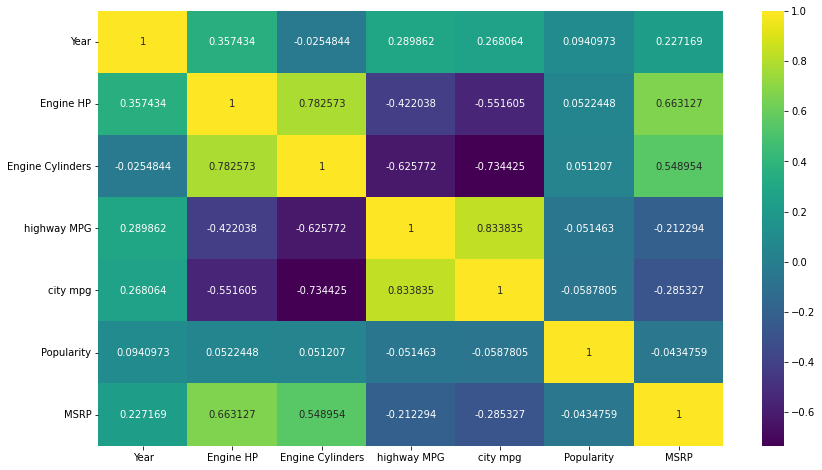

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(14,8))
sns.heatmap(corr_df, annot=True, fmt="g", cmap='viridis')

#### **Observations**:

##### Positive correlation:
1.   Cylinders and HP - higher the number of cyclinders higher will be the horse power.
2.   Highway mpg and City mpg - higher the highway mpg higher will be the city mpg.

##### Negative correlation:
1.   MPG and Cylinders - higher the number of cyclinders lesser will be the MPG.
2.   MPG and HP - higher the number of Power lesser will be the MPG.

##### No correlation:
1.   Highway mpg and Popularity
2.   City mpg and Popularity
3.   Cylinders and Popularity

### Asking and Answering Questions

#### Question 1:
Has use of diesel cars increased or decreased over the years?

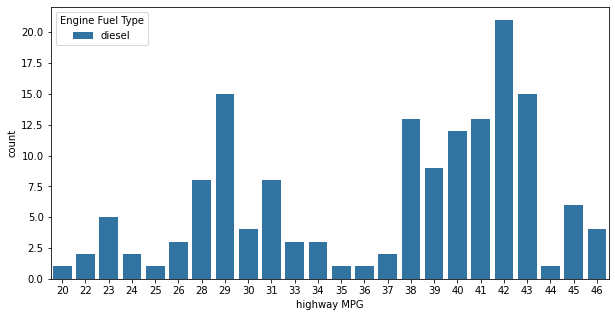

In [ ]:
plot_df = df.toPandas()
plt.figure(figsize=(10,5))
diesel_df = plot_df[plot_df['Engine Fuel Type'].str.contains('diesel')]
ax = sns.countplot(x="highway MPG", hue="Engine Fuel Type", data=diesel_df)
plt.show()

**Answer:** Use of diesel cars increased steadily from 2010 to 2015. Thereafter, the usage has gone down drastically.

#### Question 2: 
Do higher priced cars *come* with more powerful engines, that is, higher horsepower?

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  


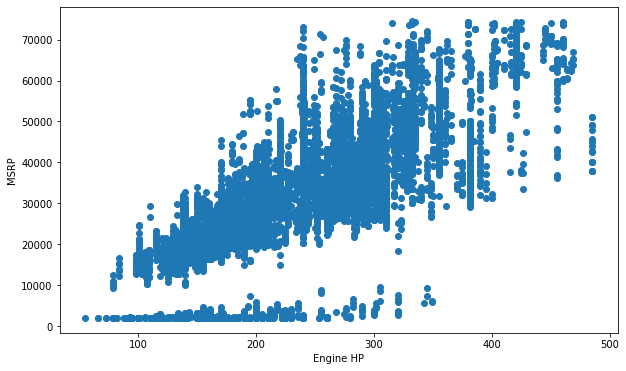

In [ ]:
plot_df = df.toPandas()
costly_df = plot_df.copy()
Q1 = costly_df.quantile(0.25)
Q3 = costly_df.quantile(0.75)
IQR = Q3 - Q1
costly_df = costly_df[~((costly_df < (Q1-1.5 * IQR)) |(costly_df > (Q3 + 1.5 * IQR))).any(axis=1)]
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(costly_df['Engine HP'], costly_df['MSRP'])
ax.set_xlabel('Engine HP')
ax.set_ylabel('MSRP')
plt.show()

**Answer:** Scatterplot above suggests that, yes higher priced cars do provide higher engine horse power.

#### Question 3:
Has production of SUVs increased over the years?

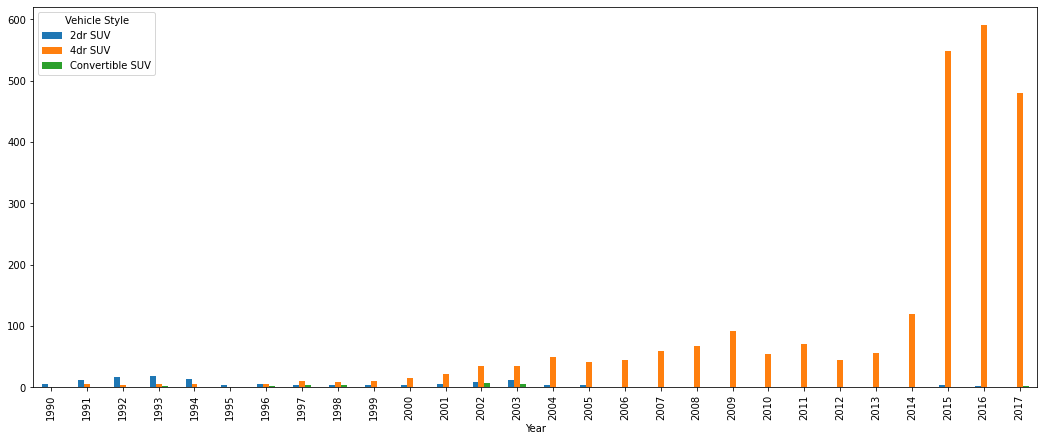

In [ ]:
import numpy as np
plot_df = df.toPandas()
vs_df = plot_df[plot_df['Vehicle Style'].str.contains('SUV')].groupby(['Year', 'Vehicle Style']).size().reset_index(name="Count");
df_pivot =  pd.pivot_table(
    vs_df, 
    values="Count",
    index="Year",
    columns="Vehicle Style",
    aggfunc=np.mean
)
df_pivot.plot(kind="bar", figsize=(18, 7));

**Answer:** From the graph we can cleary see that SUV production has gone up significantly as compared to previous decades.

#### Question 4:
Which brand is least popular and which one is most popular?

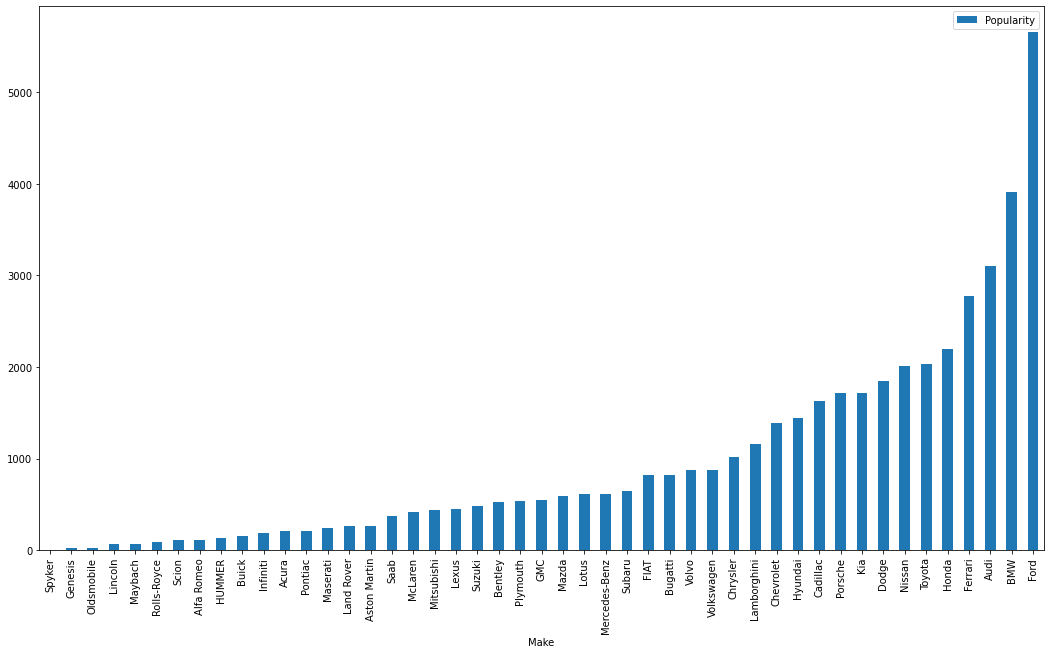

In [ ]:
plot_df = df.toPandas()
popcars_df = plot_df[['Make', 'Popularity']].sort_values('Popularity')
popcars_df = popcars_df.drop_duplicates()
popcars_df.plot(kind="bar", x="Make", figsize=(18,10));

**Answer:** Genesis is least popular while BMW is the most popular brand.

#### Question 5:
Does higher miles per gallon (MPG) value provide higher horse power?

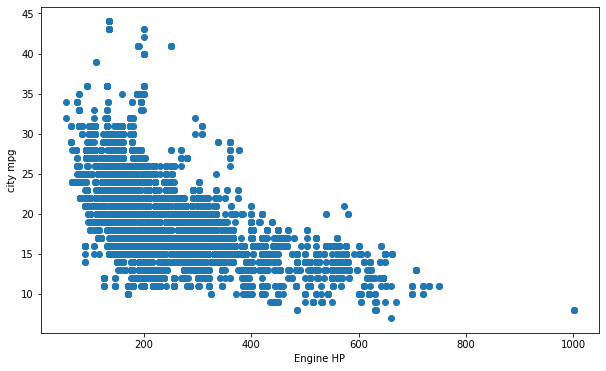

In [ ]:
plot_df = df.toPandas()
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(plot_df['Engine HP'], plot_df['city mpg'])
ax.set_xlabel('Engine HP')
ax.set_ylabel('city mpg')
plt.show()

**Answer:** 
Scatterplot above suggests that, no, higher MPG value does not provide higher power.

### Data Visualizations

#### Univariate Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


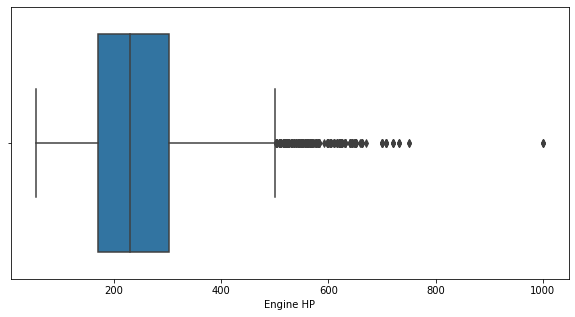

In [ ]:
# BOXPLOT
x = df.select('Engine HP').toPandas()
plt.figure(figsize=(10,5))
sns.boxplot('Engine HP',data=x)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


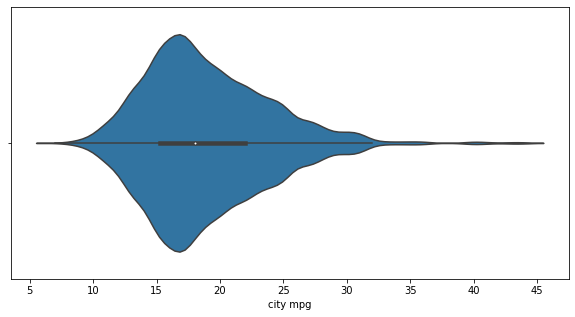

In [ ]:
# VIOLIN PLOT
x = df.select('city mpg').toPandas()
plt.figure(figsize=(10,5))
sns.violinplot('city mpg',data=x)

#### Bivariate Analysis

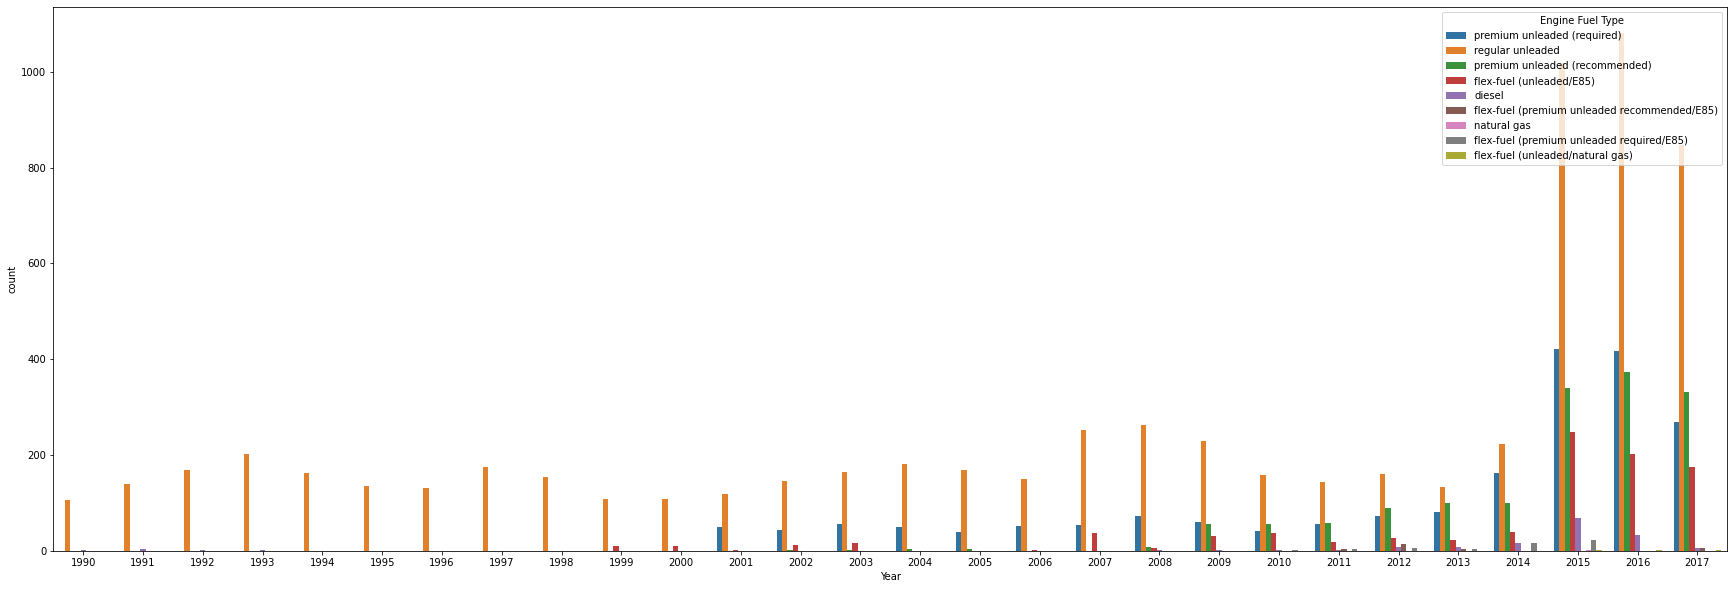

In [ ]:
#BAR PLOT
plt.figure(figsize=(30,10))
ax = sns.countplot(x="Year", hue="Engine Fuel Type", data=plot_df)
plt.show()

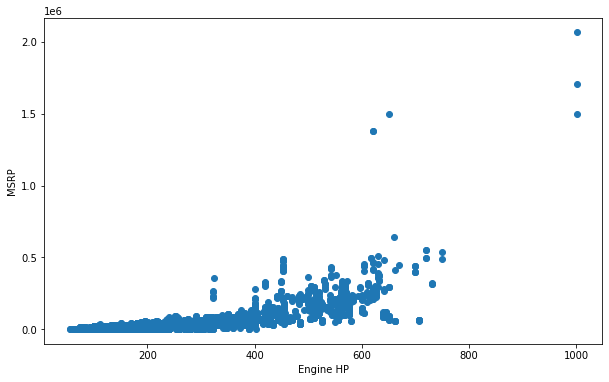

In [ ]:
#SCATTER PLOT
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(plot_df['Engine HP'], plot_df['MSRP'])
ax.set_xlabel('Engine HP')
ax.set_ylabel('MSRP')
plt.show()

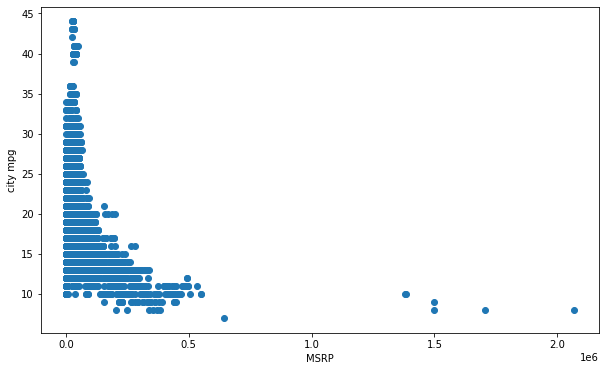

In [ ]:
#SCATTER PLOT
fig, ax = plt.subplots(figsize=(10,6))
ax.scatter(plot_df['MSRP'], plot_df['city mpg'])
ax.set_xlabel('MSRP')
ax.set_ylabel('city mpg')
plt.show()

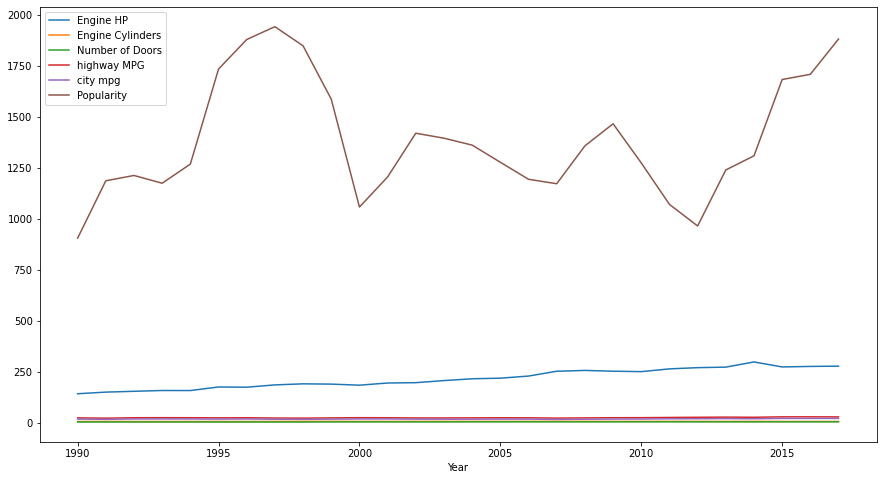

In [ ]:
#LINE PLOT
df1 = plot_df
df1 = df1.drop(['MSRP'], axis=1) 
df1.groupby(['Year']).mean().plot(figsize=(15,8))

### Graphs and some inferences drawn from them

Text(0.5, 1.0, 'Market share of Car Brands')

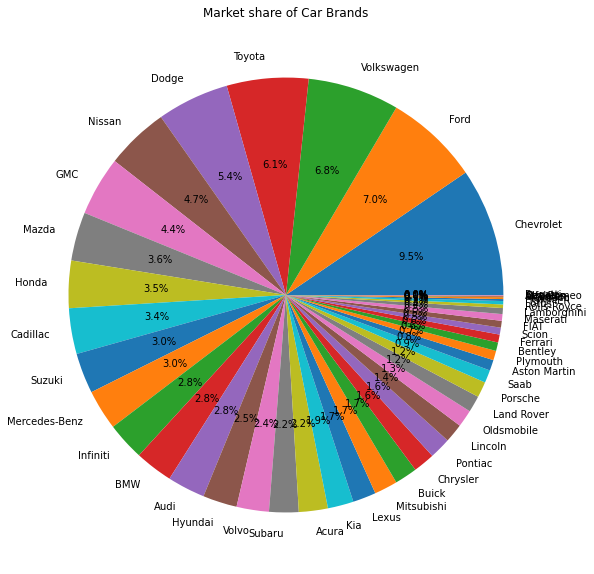

In [ ]:
plot_df = df.toPandas()
labels=plot_df['Make'].value_counts().keys()
size=plot_df['Make'].value_counts()
plt.figure(figsize=(15,10))
plt.pie(size,labels=labels,autopct="%.1f%%",)
plt.title("Market share of Car Brands")

# import plotly.express as px
# labels = ["Chevrolet","Ford","Volkswagen","Toyota","Dodge","Nissan","GMC","Mazda","Honda","Cadillac","Suzuki","Mercedes-Benz"]
# values = df.loc[0, ["sum(Chevrolet)","sum(Ford)","sum(Volkswagen)","sum(Toyota)","sum(Dodge)","sum(Nissan)","sum(GMC)","sum(Mazda)","sum(Honda)","sum(Cadillac)","sum(Suzuki)","sum(Mercedes-Benz)"] ]
# fig = px.pie(df, values=values, names=labels)
# fig.update_layout( title='Market Share of Car Brands' )
# fig.show()

**Conclusion**: Chevrolet sold the most number of cars

Text(0.5, 1.0, 'Market share of Transimission Type')

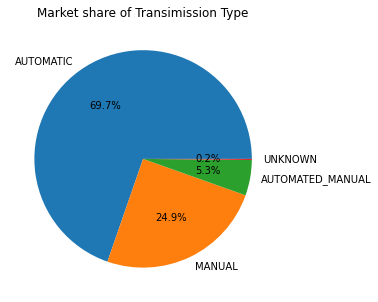

In [ ]:
plot_df = df.toPandas()
labels=plot_df["Transmission Type"].value_counts(ascending=False).keys()   
size=plot_df["Transmission Type"].value_counts(ascending=False)
explode=[0,0.07,0.1,0.5]
colors=["blue","purple","red","black"]
plt.figure(figsize=(10,5))
plt.pie(size, labels=labels, autopct="%.1f%%")
plt.title("Market share of Transimission Type")

**Conclusion:** Most people prefer an automatic transmission car over other types

Text(0.5, 1.0, 'No of units sold per Vehicle Style')

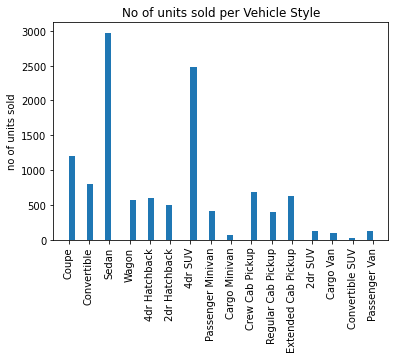

In [ ]:
plot_df = df.toPandas()
plt.hist(plot_df["Vehicle Style"],bins=50)
plt.xticks(rotation=90)
plt.ylabel("no of units sold")
plt.title("No of units sold per Vehicle Style")

**Conclusion**: Sedan was the most sold vehicle style.



Text(0.5, 1.0, 'No of units sold over the Years')

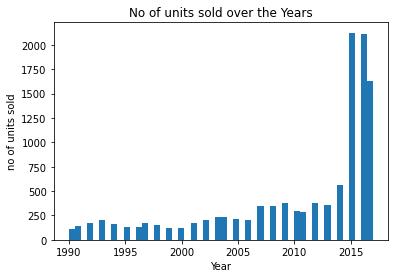

In [ ]:
plot_df = df.toPandas()
plt.hist(plot_df["Year"],bins=50)
plt.xlabel("Year")
plt.ylabel("no of units sold")
plt.title("No of units sold over the Years")

**Conclusion**: In the year 2015 there was a spike in car sales

<BarContainer object of 9 artists>

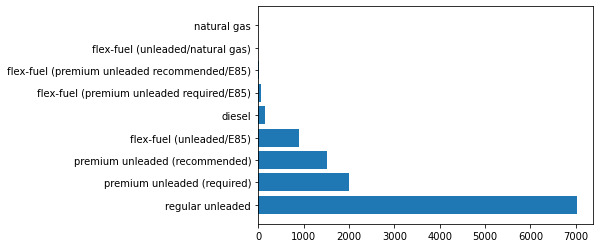

In [ ]:
plot_df = df.toPandas()
plt.barh(plot_df['Engine Fuel Type'].value_counts(ascending=False).index[:10],plot_df['Engine Fuel Type'].value_counts(ascending=False)[:10])

**Conclusion**: Regular unleaded is the most popular engine fuel type